<a href="https://colab.research.google.com/github/Md-Aziz-Developer/dog-vision/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to end  multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I.m sitting at the cafe and I take a photo of a dog, I want to knwo what breed fo dog it is.

## 2. Data

The data we're using is from Kaggle-s dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction for each dog breed of each test image.

www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (Unstructured data) so it's probably best we use deed learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000 + images in the traning set (these images have labels).
* There are around 10,000 + images in the test set (these images have no labels, because we'll want to predict them).

In [ ]:
# Unzip the Uploaded data into Google Drive
#!unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

### Get our workspace ready

* Import TensorFlow 2.x
* Import TensotFlow Hub
* Make sure we're using a GPU

In [1]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ",tf.__version__)
print("TF Hubb versionL ",hub.__version__)

# Check for GPU availablilty
print("GPU","available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "Not available :(")

TF version:  2.17.0
TF Hubb versionL  0.16.1
GPU available (YESSSS!!!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by asscessing our data and checking out the labels.

In [2]:
# Checkout the labels of our data
import pandas as pd
labels_csv=pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [3]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: xlabel='breed'>

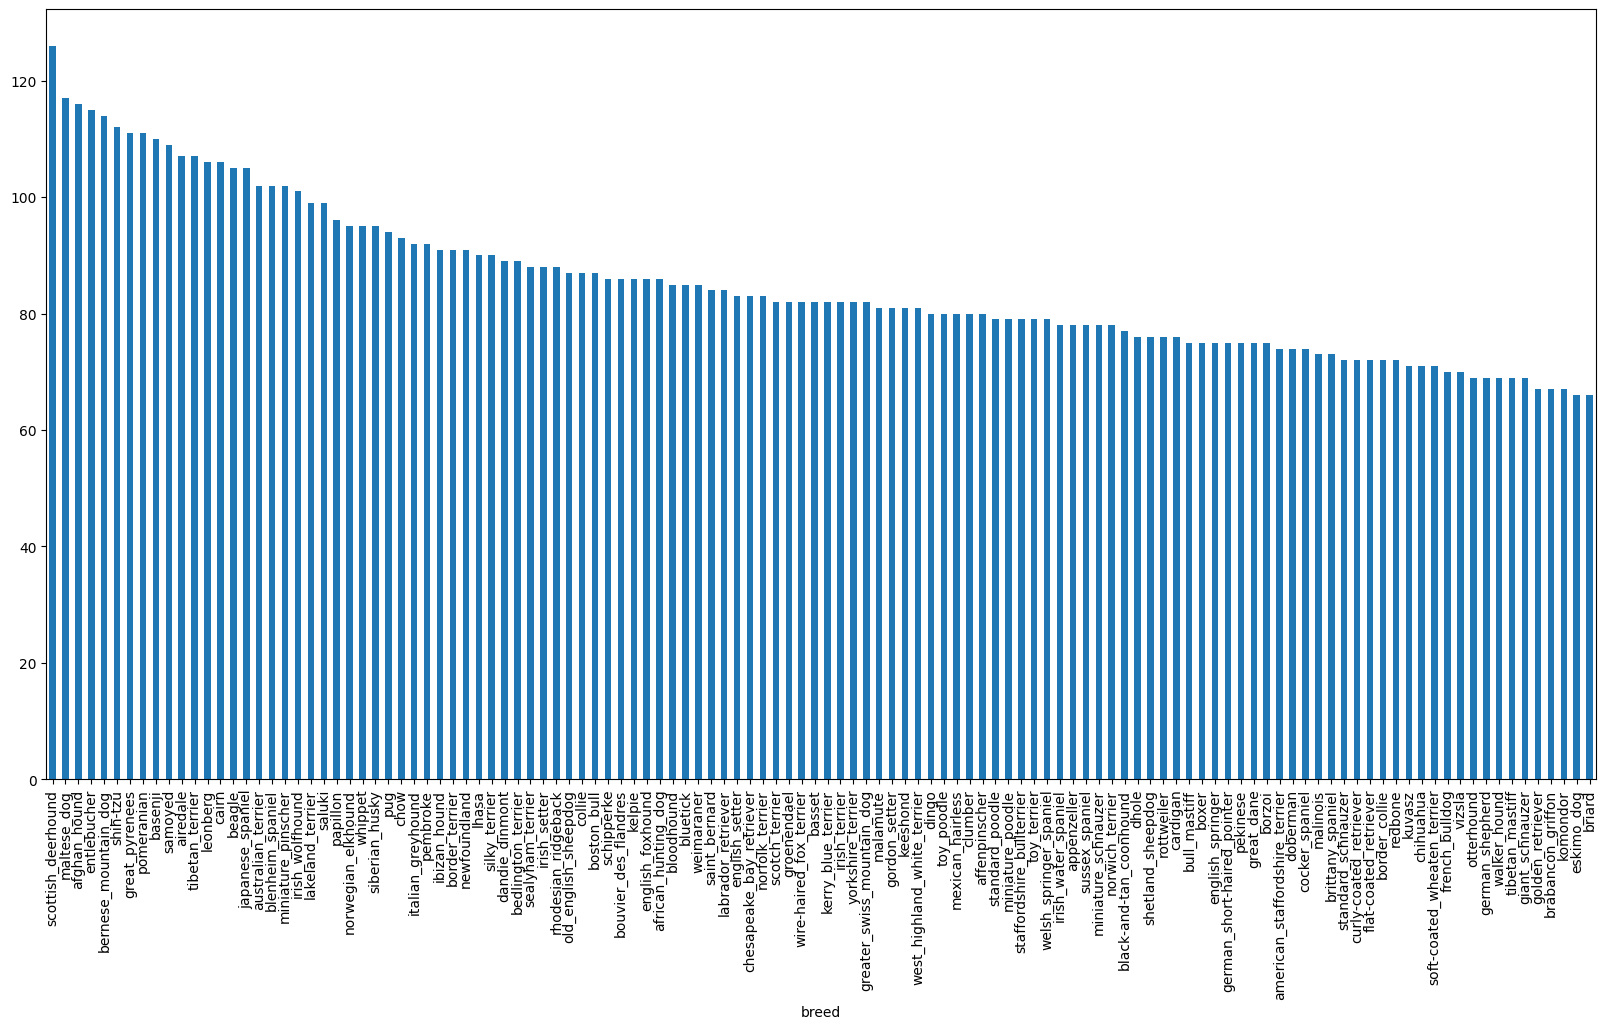

In [4]:
# How many images are there of each bread?
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10))

In [5]:
labels_csv['breed'].value_counts().median()

82.0

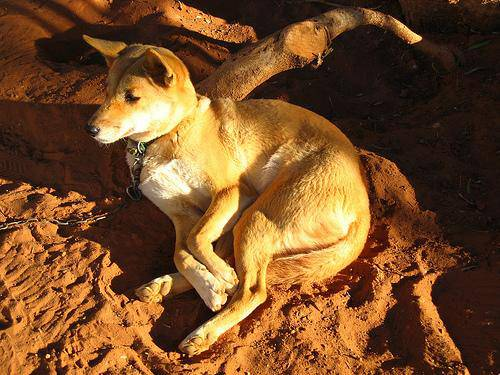

In [6]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting image and their labels

Let's get a list of all of our image file pathnames.

In [7]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
# Create pathnames from image ID's
filenames=['drive/MyDrive/Dog Vision/train/'+fname+'.jpg' for fname in labels_csv['id']]

# Check the first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [9]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir('drive/MyDrive/Dog Vision/train/'))==len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


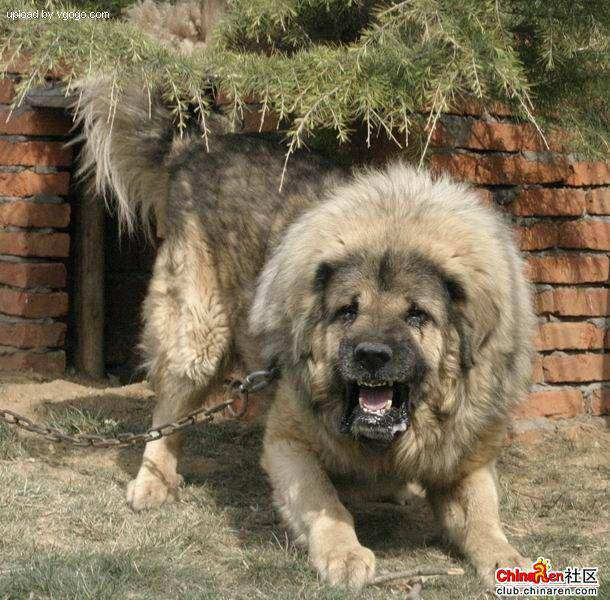

In [10]:
# one more check
Image(filenames[9000])

In [11]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [14]:
import numpy as np
labels=labels_csv['breed'].to_numpy()
# labels=np.array(labels) # does same things as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [18]:
# Find the unique label values
unique_breeds=np.unique(labels)
unique_breeds, len(unique_breeds)

(array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter', 'gre

In [19]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0]==unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [20]:
# Turn every label into a boolean array
boolean_labels=[label==unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [21]:
len(boolean_labels)

10222

In [23]:
# Examples : Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds==labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [25]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [24]:
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set

since the dataset from kaggle doesn't come with a validation set, we're going to create our own.

In [27]:
# Setup X & y variables
X=filenames
y=boolean_labels

In [26]:
len(filenames)

10222

We're going to start off experimenting with ~ 1000 images and increase as needed.

In [29]:
# Set a number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000,max:10000,step:100}

In [30]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into traning and validation of total size NUM_IMAGES
X_train, X_val, y_train,y_val=train_test_split(X[:NUM_IMAGES],
                                               y[:NUM_IMAGES],
                                               test_size=0.2,
                                               random_state=42
                                               )

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [31]:
# Let's have a geez at the training data
X_train[:5], y_train[:5]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Preprocessing Images (tunning image into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be shape of (224,224)
5. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [33]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image=imread(filenames[42])
image.shape

(257, 350, 3)

In [35]:
image.max(), image.min()

(255, 0)

In [37]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [36]:
# Turn image into a tensor
tf.constant(image[:2])

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be shape of (224,224)
6. Return the modified `image`

In [47]:
# Define image size
IMG_SIZE=224

# Create a function for preprocessing images
def process_image(image_path,img_size=IMG_SIZE):
  """
  Takes an imahe file path and turn the image into a Tensor.
  """
  # Read in an image file
  image=tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image=tf.image.decode_jpeg(image,channels=3)
  # Convert the colur channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image,tf.float32)
  # Resize the imahe to our desired value (224,224)
  image=tf.image.resize(image, size=(img_size,img_size))

  return image


In [41]:
tensor=tf.io.read_file(filenames[26])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\xf4\x01w\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [45]:
tensor=tf.image.decode_jpeg(tensor,channels=3)

In [46]:
tf.image.convert_image_dtype(tensor, tf.float32)

<tf.Tensor: shape=(500, 375, 3), dtype=float32, numpy=
array([[[0.23137257, 0.26666668, 0.25490198],
        [0.2509804 , 0.28627452, 0.27450982],
        [0.2784314 , 0.3137255 , 0.3019608 ],
        ...,
        [0.45098042, 0.5019608 , 0.42352945],
        [0.45098042, 0.5019608 , 0.42352945],
        [0.43137258, 0.48235297, 0.4039216 ]],

       [[0.25490198, 0.2901961 , 0.2784314 ],
        [0.28235295, 0.31764707, 0.30588236],
        [0.30980393, 0.34509805, 0.33333334],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.45882356, 0.50980395, 0.43137258],
        [0.454902  , 0.5058824 , 0.427451  ]],

       [[0.26666668, 0.3019608 , 0.2901961 ],
        [0.29803923, 0.33333334, 0.32156864],
        [0.3254902 , 0.36078432, 0.34901962],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.47058827, 0.52156866, 0.4431373 ],
        [0.48235297, 0.53333336, 0.454902  ]],

       ...,

       [[0.6784314 , 0.7843138 , 0.60784316],
        [0.64

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go. they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In Order to use TensorFLow effectlively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`.

In [48]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path,label):
  """
  Takes an image file path name and the associated label.
  processes the image and returns a tuple of (image,label).
  """
  image=process_image(image_path)
  return image,label

In [52]:
# Demo of the above
(process_image(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to tunr our data into tuple of Tensors in the form: `(image,label)`, let's make a function to turn all of our data (`x` & `y`) into batches!

In [63]:
# Define the batch size, 32 is a good start
BATCH_SIZE=32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's a traning data but doesn;t shuffle if it's a validation data.
  Also accepts test data as input (no labels).
  """

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch=data.map(process_image).batch(batch_size)
    return data_batch

    # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                            tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                            tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling image
    data=data.shuffle(buffer_size=len(X))

    # Create (image,label) tuples (this also turns then image path into a preprocessed image)
    data=data.map(get_image_label)

    # Turn the traning data into batches
    data_batch =data.batch(batch_size)
    return data_batch


In [64]:
# Create training and validation data batches
train_data=create_data_batches(X_train,y_train)
val_data=create_data_batches(X_val,y_val,valid_data=True)


Creating training data batches...
Creating validation data batches...


In [65]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches however, these can be a little hard to understand/comprehend, let's visualize them!

In [71]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images,labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """

  # Setup  the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # create subplots (5 rows, 5 columns)
    ax=plt.subplot(5,5,i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid line off
    plt.axis('off')



In [67]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [68]:
train_images, train_labels=next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[4.33028072e-01, 3.84143054e-01, 2.64630407e-01],
          [5.88110566e-01, 5.25634706e-01, 4.03371215e-01],
          [6.32157147e-01, 5.55553019e-01, 4.29140449e-01],
          ...,
          [5.36316156e-01, 5.23389339e-01, 6.05006993e-01],
          [4.97143120e-01, 4.37855631e-01, 4.85558927e-01],
          [4.54490572e-01, 3.58544528e-01, 3.77066940e-01]],
 
         [[3.37727636e-01, 3.35737288e-01, 3.00948679e-01],
          [4.67511415e-01, 4.48052377e-01, 3.98150861e-01],
          [5.41135967e-01, 4.98918951e-01, 4.32995260e-01],
          ...,
          [5.42316675e-01, 5.61475873e-01, 6.25281215e-01],
          [4.56466675e-01, 4.44570690e-01, 4.75251675e-01],
          [3.60591769e-01, 3.23263526e-01, 3.24536085e-01]],
 
         [[3.47181410e-01, 3.44479859e-01, 3.13264847e-01],
          [4.93091315e-01, 4.68775213e-01, 4.13724422e-01],
          [5.99110425e-01, 5.38236380e-01, 4.49794322e-01],
          ...,
          [1.59141928e-01, 2.16134876e-01, 2.5010

In [69]:
len(train_images), len(train_labels)

(32, 32)

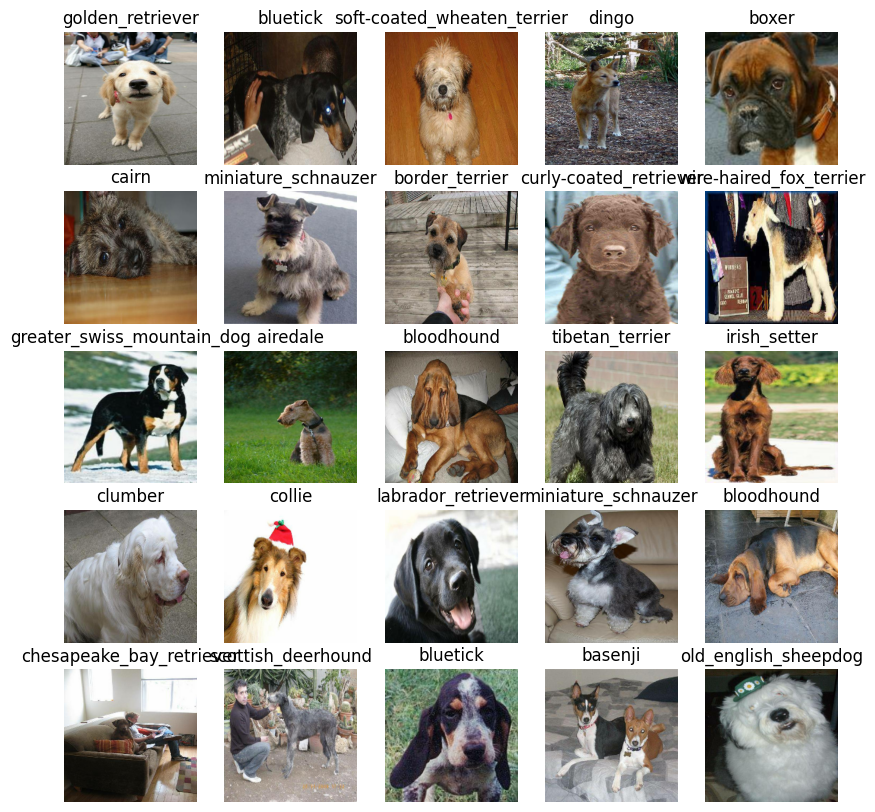

In [72]:
# Now let's visualize the data in a training batch
show_25_images(train_images,train_labels)

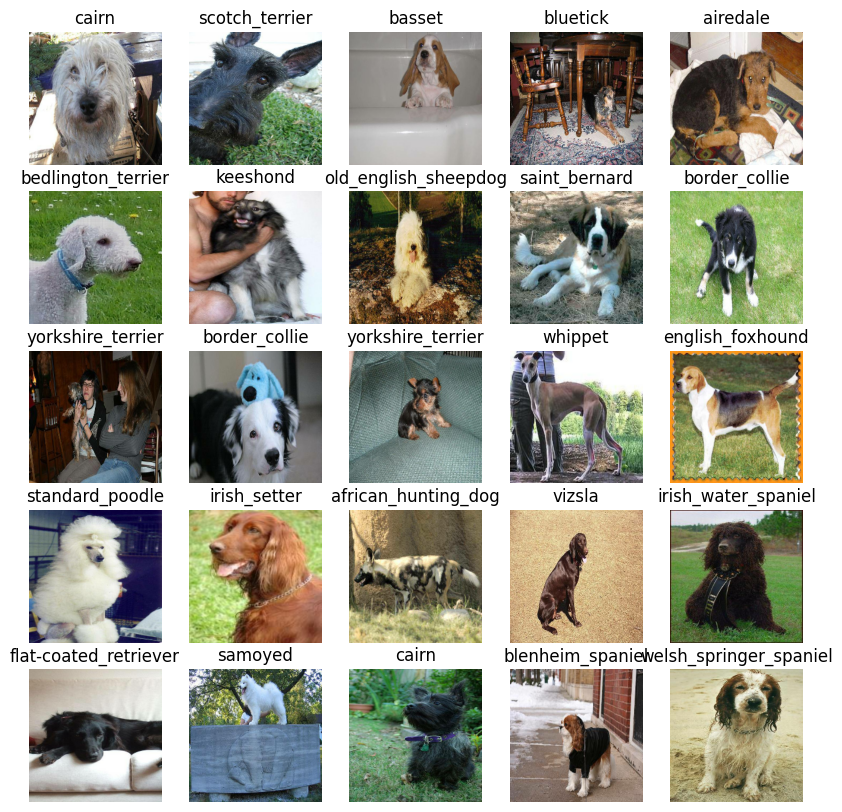

In [73]:
# Now let's visualize the data in a validation batch
val_images,val_labels=next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

## Building the model

Before we build a model, there are few things we need to define:
* The input shape(our images shape, inthe form of Tensors) to iur model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.


In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3] # batch, height width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE=len(unique_breeds)

# Setup model URL from TensorFLow Hub
MODEL_URL=...